# Setup
Install required Python packages.

In [56]:
# !conda install matplotlib scikit-learn pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

# Dataset
Initialise and prepare FashionMNIST dataset.

In [57]:
import torch, torchvision
import torchvision.transforms as transforms

# Check if graphics card is available, otherwise use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 10
BATCH_SIZE = 200
LEARNING_RATE = 0.001

# Normalize to Tensor of normalize range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

# Load in FashionMNIST train and test set
train_dataset = torchvision.datasets.FashionMNIST(root="dataset", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root="dataset", train=False, download=True, transform=transform)

# Load dataset into dataloader for batch iterations
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# All 10 available classes for the FashionMNIST dataset
classes= ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

In [58]:
# Examine a sample
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([200, 1, 28, 28])
torch.Size([200])


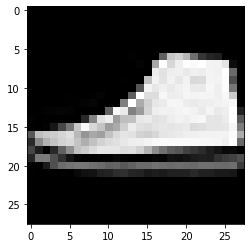

In [59]:
import matplotlib.pyplot as plt

# Show sample
plt.imshow(images[0].numpy().squeeze(), cmap="Greys_r")

# Neural Network

In [60]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple

# Full credits of this class go to rwightman
# https://gist.github.com/rwightman/f2d3849281624be7c0f11c85c87c1598
class MedianPool2d(nn.Module):
    """ Median pool (usable as median filter when stride=1) module.
    
    Args:
         kernel_size: size of pooling kernel, int or 2-tuple
         stride: pool stride, int or 2-tuple
         padding: pool padding, int or 4-tuple (l, r, t, b) as in pytorch F.pad
         same: override padding and enforce same padding, boolean
    """
    def __init__(self, kernel_size=3, stride=1, padding=0, same=False):
        super(MedianPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding
    
    def forward(self, x):
        # using existing pytorch functions and tensor ops so that we get autograd, 
        # would likely be more efficient to implement from scratch at C/Cuda level
        x = F.pad(x, self._padding(x), mode='reflect')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        return x

In [61]:
import random

def pad_img_tensor(x, img_size):
    """ Resize and pad image randomly to given img_size. Used as defense.
    
    Args:
         x: 4-dimensional tensor which includes image(s) to be resized and padded in the 1st and 2nd dimension
         img_size: Width and height of input image x given as single int
    """
    width = random.randint(img_size - 5, img_size)
    height = random.randint(img_size - 5, img_size)
    resized_image = transforms.functional.resize(x, size=(width,height))
    shape = list(resized_image.shape)
    width = shape[2]
    height = shape[3]
    padding_width = random.randint(0, img_size-width)
    padding_height = random.randint(0, img_size-height)
    if (random.randint(0, 1)):
        padding_width_right = padding_width
        padding_width_left = img_size - width - padding_width
        padding_height_top = padding_height
        padding_height_bottom = img_size - height - padding_height
    else:
        padding_width_right = img_size - width - padding_width
        padding_width_left = padding_width
        padding_height_top = img_size - height - padding_height
        padding_height_bottom = padding_height
    x = transforms.functional.pad(resized_image, padding=(padding_height_top, padding_width_left, padding_height_bottom, padding_width_right))
    return x

class CNN(nn.Module):
    def __init__(self, medianFilter, padding, img_size):
        """ Convolutional Neural Network.
    
        Args:
             medianFilter: Boolean to check if input should be smoothed with a median filter
             padding: Boolean to check if input should be resized and padded
             img_size: The size of the image or to which size the image should be resized and padded
        """
        super().__init__()
        self.medianFilter = medianFilter
        self.padding = padding
        self.img_size = img_size
        self.medianPool = MedianPool2d(2, 1, same=True)
        # Input: 1 x img_size x img_size
        # 1 input channel, 5 output channels, kernel size of 7x7
        # Output: 5 x img_size-6 x img_size-6 due to kernelsize = 7
        self.conv1 = nn.Conv2d(1, 5, 7)
        self.conv1_drop = nn.Dropout2d(0.2)
        # Input: 5 x img_size-6 x img_size-6
        # 5 input channel, 12 output channels, kernel size of 5x5
        # Output: 12 x img_size-10 x img_size-10 due to kernelsize = 5
        self.conv2 = nn.Conv2d(5, 12, 5)
        self.conv2_drop = nn.Dropout2d(0.2)
        # Input: 12 x img_size-10 x img_size-10
        # Kernel size of 2x2
        # Output: 12 x (img_size-10)/2 x (img_size-10)/2
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(int(12 * ((self.img_size-10)/2) * ((self.img_size-10)/2)), 256)
        self.fc_drop = nn.Dropout2d(0.3)
        self.fc2 = nn.Linear(256, 10)
        pass

    def forward(self, x):
        if (self.medianFilter):
            x = self.medianPool(x)
        if (self.padding):
            x = pad_img_tensor(x, self.img_size)
        x = self.conv1(x)
        x = self.conv1_drop(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc_drop(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class DEF_RESNET(nn.Module):
    def __init__(self, precreated_model, medianFilter, padding, img_size):
        """ Extension on the ResNet model. Integrate defense methods.
    
        Args:
             precreated_model: Other NN that is used within this NN
             medianFilter: Boolean to check if input should be smoothed with a median filter
             img_size: The size of the image or to which size the image should be resized and padded
        """
        super().__init__()
        self.precreated = precreated_model
        self.medianFilter = medianFilter
        self.padding = padding
        self.img_size = img_size
        self.medianPool = MedianPool2d(2, 1, same=True)
        pass
    
    def forward(self, x):
        if (self.medianFilter):
            x = self.medianPool(x)
        if (self.padding):
            x = pad_img_tensor(x, self.img_size)
        x = self.precreated(x)
        return x

In [62]:
from torchvision.models import resnet50

# Use own CNN model or use precreated Resnet50 model
USE_OWN_NN = True

if (USE_OWN_NN):
    model = CNN(False, False, 28)
else:
    model = DEF_RESNET(resnet50(), False, False, 28)
    # Replace first convolutional layer as to make it possible to use single color images
    model.precreated.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

CNN(
  (medianPool): MedianPool2d()
  (conv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1))
  (conv1_drop): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(5, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=972, out_features=256, bias=True)
  (fc_drop): Dropout2d(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [63]:
import time, math
from sklearn.metrics import accuracy_score

def train():
    start = time.time()
    train_losses = []
    test_losses = []

    for epoch in range(EPOCHS):

        # Train mode
        model.train()

        for i, batch in enumerate(train_loader):
            # Send data to device
            inputs, labels = batch[0].to(device), batch[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                train_loss = criterion(outputs, labels)
                train_loss.backward()
                optimizer.step()

            # Setup batch statistics
            preds = torch.argmax(outputs, dim=1)
            correct = torch.sum(torch.eq(preds, labels)).item()
            elapsed = time.time() - start

            # Print training statistics
            if not i % (math.ceil(len(train_loader) / 4)):
                    print(f'epoch: {epoch}, batch: {i:<{len(str(len(train_loader)))}}/{len(train_loader)}, time: {elapsed:.3f}s, loss: {train_loss.item():.3f}, acc: {correct / BATCH_SIZE:.3f}')
            
        train_losses.append(train_loss.item())

        # Evaluation mode
        model.eval()
        
        batch_acc = []

        for i, batch in enumerate(test_loader):
            # Send data to device
            inputs, labels = batch[0].to(device), batch[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                preds = preds.to(device).tolist()
                batch_acc.append(accuracy_score(preds, labels.tolist()))
                test_loss = criterion(outputs, labels.long())

        # Print test statistics
        print(f'Accuracy on the test set: {sum(batch_acc)/len(batch_acc):.3f}')

        test_losses.append(test_loss.item())
    return (train_losses, test_losses)
train_losses, test_losses = train()

epoch: 0, batch: 0  /300, time: 0.089s, loss: 2.312, acc: 0.055
epoch: 0, batch: 75 /300, time: 3.057s, loss: 0.719, acc: 0.745
epoch: 0, batch: 150/300, time: 5.712s, loss: 0.644, acc: 0.735
epoch: 0, batch: 225/300, time: 8.394s, loss: 0.523, acc: 0.820
Accuracy on the test set: 0.821
epoch: 1, batch: 0  /300, time: 12.906s, loss: 0.476, acc: 0.825
epoch: 1, batch: 75 /300, time: 15.632s, loss: 0.496, acc: 0.825
epoch: 1, batch: 150/300, time: 18.497s, loss: 0.514, acc: 0.815
epoch: 1, batch: 225/300, time: 21.328s, loss: 0.384, acc: 0.870
Accuracy on the test set: 0.849
epoch: 2, batch: 0  /300, time: 25.821s, loss: 0.529, acc: 0.805
epoch: 2, batch: 75 /300, time: 28.574s, loss: 0.475, acc: 0.840
epoch: 2, batch: 150/300, time: 31.357s, loss: 0.419, acc: 0.875
epoch: 2, batch: 225/300, time: 34.091s, loss: 0.465, acc: 0.840
Accuracy on the test set: 0.859
epoch: 3, batch: 0  /300, time: 38.475s, loss: 0.462, acc: 0.845
epoch: 3, batch: 75 /300, time: 41.166s, loss: 0.430, acc: 0.85

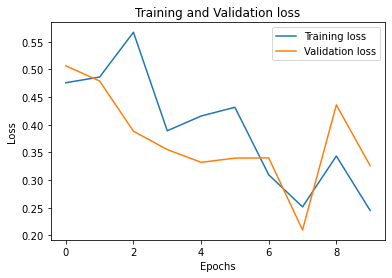

In [64]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Save trained model

In [65]:
import os

path = "model/"
if not os.path.exists(path):
  os.makedirs(path)

if (USE_OWN_NN):
  torch.save(model.state_dict(), path + "own_model.pth")
else:
  torch.save(model.state_dict(), path + "resnet_model.pth")

## Load trained model

In [66]:
path = "model/"
if (USE_OWN_NN):
    CNN(False, False, 28)
    model.load_state_dict(torch.load(path + "own_model.pth"))
else:
    model = DEF_RESNET(resnet50(), False, False, 28)
    # Replace first convolutional layer as to make it possible to use single color images
    model.precreated.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.load_state_dict(torch.load(path + "resnet_model.pth"))
model = model.to(device)
model.eval()

CNN(
  (medianPool): MedianPool2d()
  (conv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1))
  (conv1_drop): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(5, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=972, out_features=256, bias=True)
  (fc_drop): Dropout2d(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

# Attacks  

FGSM:  
$x_{new}=x+\epsilon*sign(\nabla_{x}J(\theta,x,y))$  

I-FGSM:  
$x^{(i+1)}_{new} = Clip_{X,\epsilon}\{x^{(i)}+step*sign(\nabla_{x^{(i)}}J(\theta,x^{(i)},y))\}$  
$x^{(0)}=x$  

MI-FGSM:  
$x^{(i+1)}_{new} = Clip_{X,\epsilon}\{x^{(i)}+step*sign(g^{(i+1)})\}$  
$g^{(i+1)} = \mu*g^{(i)}+\frac{\nabla_{x^{(i)}}J(\theta,x^{(i)},y)}{||\nabla_{x^{(i)}}J(\theta,x^{(i)},y)||_{l_{1}}}$  
$g^{(0)}=0$
$x^{(0)}=x$

In [85]:
import sys

# FGSM attack code
def fgsm(model, image, label, epsilon):
    # Classify the image with the trained model
    output = model(image)
    # Calculate the loss
    cost = criterion(output, label).to(device)
    # Zero all existing gradients
    model.zero_grad()
    # Calculate gradients of model in backward pass
    cost.backward()
    # Collect datagrad
    data_grad = image.grad.data
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [-1,1] range
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    # Return the perturbed image
    return perturbed_image
        
def iterative_fgsm(model, image, label, epsilon, num_steps=40):
    step = epsilon/num_steps
    image = image.clone().detach()
    adv_image = image.clone().detach()
    for _ in range(num_steps):
        # Set requires_grad attribute of tensor
        adv_image.requires_grad = True
        # Classify the image with the trained model
        output = model(adv_image)
        # Calculate the loss
        cost = criterion(output, label).to(device)
        # Calculate gradients of model in backward pass
        cost.backward()
        # Collect datagrad
        data_grad = adv_image.grad.data
        # Create the perturbed image by adjusting each pixel of the input image with the element-wise sign of the data gradient
        adv_image = adv_image.detach() + step*data_grad.sign()
        # Adding clipping so that the image alteration doesn't exceed epsilon
        eta = torch.clamp(adv_image - image, min=-epsilon, max=epsilon)
        # Adding clipping to maintain [-1,1] range
        adv_image = torch.clamp(image + eta, min=-1, max=1).detach()
        image = adv_image.clone().detach()
    return adv_image

def momentum_iterative_fgsm(model, image, label, epsilon, num_steps=40, decay=0.2):
    step = epsilon/num_steps
    # Initialize momentum
    momentum = torch.zeros_like(image).detach().to(device)
    image = image.clone().detach()
    adv_image = image.clone().detach()
    for _ in range(num_steps):
        # Set requires_grad attribute of tensor
        adv_image.requires_grad = True
        # Classify the image with the trained model
        output = model(adv_image)
        # Calculate the loss
        cost = criterion(output, label).to(device)
        # Calculate gradients of model in backward pass
        cost.backward()
        # Collect datagrad
        data_grad = adv_image.grad.data
        grad = data_grad / torch.mean(torch.abs(data_grad), dim=(1,2,3), keepdim=True)
        momentum = grad + momentum * decay
        # Create the perturbed image by adjusting each pixel of the input image with the element-wise sign of the data gradient
        adv_image = adv_image.detach() + step*momentum.sign()
        # Adding clipping so that the image alteration doesn't exceed epsilon
        eta = torch.clamp(adv_image - image, min=-epsilon, max=epsilon)
        # Adding clipping to maintain [-1,1] range
        adv_image = torch.clamp(image + eta, min=-1, max=1).detach()
        image = adv_image.clone().detach()
    return adv_image

def rotation(image, angle):
    adv_image = transforms.functional.rotate(image, angle, transforms.functional.InterpolationMode.NEAREST)
    return adv_image

def test(model, device, test_loader, attack, epsilon=0, angle=0):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = torch.argmax(output, dim=1)

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue
        if (attack == "fgsm"):
            # Call FGSM Attack
            perturbed_data = fgsm(model, data, target, epsilon)
        elif (attack == "iterative_fgsm"):
            perturbed_data = iterative_fgsm(model, data, target, epsilon)
        elif (attack == "momentum_iterative_fgsm"):
            perturbed_data = momentum_iterative_fgsm(model, data, target, epsilon)
        elif (attack == "rotation"):
            # Call rotation Attack
            perturbed_data = rotation(data, angle)
        else:
            print("You have selected an attack method which is not implemented.\nPlease alter " + attack + ".")
            sys.exit()
        
        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = torch.argmax(output, dim=1) # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0 or angle == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    if (attack == "rotation"):
        print("Angle: {}\tTest Accuracy = {} / {} = {}".format(angle, correct, len(test_loader), final_acc))
    else:
        print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples
    

In [86]:
EPSILONS = [0, .05, .1, .15, .2, .25, .3]
ANGLES = [0, 30, 60, 90, 120, 150, 180]
# Choose from fgsm, iterative_fgsm, momentum_iterative_fgsm, rotation 
ATTACK = "momentum_iterative_fgsm"

def adversial_attack(epsilons, attack, model):
    accuracies = []
    examples = []

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

    if (ATTACK == "rotation"):
        # Run test for each angle
        for angle in ANGLES:
            acc, ex = test(model, device, test_loader, attack, angle=angle)
            accuracies.append(acc)
            examples.append(ex)
    else:
        # Run test for each epsilon
        for eps in epsilons:
            acc, ex = test(model, device, test_loader, attack, epsilon=eps)
            accuracies.append(acc)
            examples.append(ex)
    return accuracies, examples

accuracies, examples = adversial_attack(EPSILONS, ATTACK, model)

KeyboardInterrupt: 

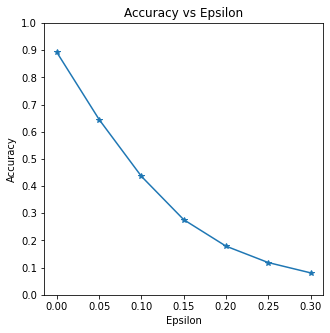

In [69]:
import numpy as np

plt.figure(figsize=(5,5))
plt.plot(EPSILONS, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

path = "results/"
if not os.path.exists(path):
  os.makedirs(path)

if (USE_OWN_NN):
    plt.savefig(path + "ownModel_" + ATTACK + "_graph.png")
else:
    plt.savefig(path + "ResNet50_" + ATTACK + "_graph.png")
plt.show()

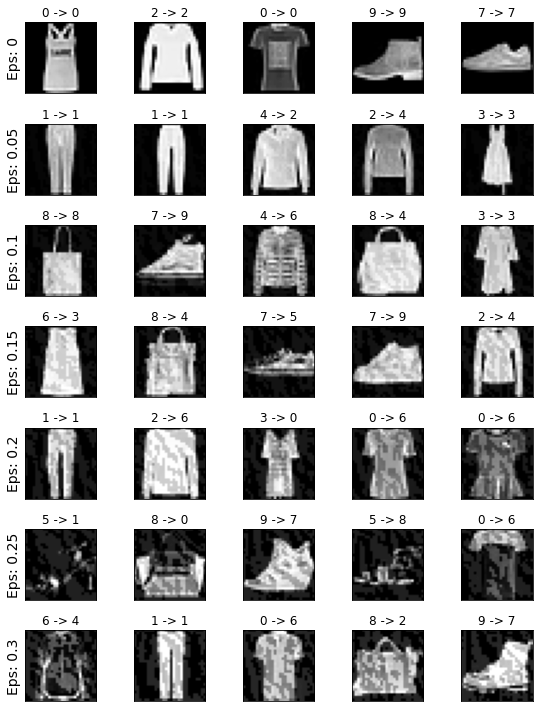

In [70]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(EPSILONS)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(EPSILONS),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(EPSILONS[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
if (USE_OWN_NN):
    plt.savefig(path + "ownModel_" + ATTACK + "_examples.png")
else:
    plt.savefig(path + "ResNet50_" + ATTACK + "_examples.png")
plt.show()

# Defense

In [71]:
SPATIAL_SMOOTHING = True
RESIZE_PADDING = False

if (RESIZE_PADDING):
    IMAGE_SIZE = 36
else:
    IMAGE_SIZE = 28

if (USE_OWN_NN):
    model = CNN(SPATIAL_SMOOTHING, RESIZE_PADDING, IMAGE_SIZE)
else:
    model = DEF_RESNET(resnet50(), SPATIAL_SMOOTHING, RESIZE_PADDING, 36)
    model.precreated.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses, test_losses = train()

epoch: 0, batch: 0  /300, time: 0.051s, loss: 2.310, acc: 0.100
epoch: 0, batch: 75 /300, time: 3.186s, loss: 0.702, acc: 0.745
epoch: 0, batch: 150/300, time: 6.440s, loss: 0.591, acc: 0.800
epoch: 0, batch: 225/300, time: 9.642s, loss: 0.519, acc: 0.810
Accuracy on the test set: 0.819
epoch: 1, batch: 0  /300, time: 14.916s, loss: 0.555, acc: 0.790
epoch: 1, batch: 75 /300, time: 18.119s, loss: 0.486, acc: 0.810
epoch: 1, batch: 150/300, time: 21.598s, loss: 0.421, acc: 0.880
epoch: 1, batch: 225/300, time: 24.742s, loss: 0.403, acc: 0.845
Accuracy on the test set: 0.843
epoch: 2, batch: 0  /300, time: 29.984s, loss: 0.329, acc: 0.880
epoch: 2, batch: 75 /300, time: 33.054s, loss: 0.422, acc: 0.835
epoch: 2, batch: 150/300, time: 36.339s, loss: 0.438, acc: 0.850
epoch: 2, batch: 225/300, time: 39.604s, loss: 0.443, acc: 0.875
Accuracy on the test set: 0.857
epoch: 3, batch: 0  /300, time: 45.112s, loss: 0.439, acc: 0.830
epoch: 3, batch: 75 /300, time: 48.755s, loss: 0.406, acc: 0.87

In [72]:
accuracies, examples = adversial_attack(EPSILONS, ATTACK, model)

Epsilon: 0	Test Accuracy = 8897 / 10000 = 0.8897
Epsilon: 0.05	Test Accuracy = 7167 / 10000 = 0.7167
Epsilon: 0.1	Test Accuracy = 5582 / 10000 = 0.5582
Epsilon: 0.15	Test Accuracy = 4321 / 10000 = 0.4321
Epsilon: 0.2	Test Accuracy = 3289 / 10000 = 0.3289
Epsilon: 0.25	Test Accuracy = 2485 / 10000 = 0.2485
Epsilon: 0.3	Test Accuracy = 1829 / 10000 = 0.1829


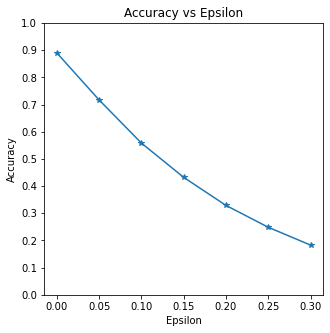

In [73]:
plt.figure(figsize=(5,5))
plt.plot(EPSILONS, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
if (USE_OWN_NN):
    if (SPATIAL_SMOOTHING and RESIZE_PADDING):
        plt.savefig(path + "ownModel_" + ATTACK + "_spatialSmoothing&resizePadding_graph.png")
    elif (SPATIAL_SMOOTHING):
        plt.savefig(path + "ownModel_" + ATTACK + "_spatialSmoothing_graph.png")
    elif (RESIZE_PADDING):
        plt.savefig(path + "ownModel_" + ATTACK + "_resizePadding_graph.png")
    else:
        plt.savefig(path + "ownModel_" + ATTACK + "_graph.png")
else:
    if (SPATIAL_SMOOTHING and RESIZE_PADDING):
        plt.savefig(path + "ResNet50_" + ATTACK + "_spatialSmoothing&resizePadding_graph.png")
    elif (SPATIAL_SMOOTHING):
        plt.savefig(path + "ResNet50_" + ATTACK + "_spatialSmoothing_graph.png")
    elif (RESIZE_PADDING):
        plt.savefig(path + "ResNet50_" + ATTACK + "_resizePadding_graph.png")
    else:
        plt.savefig(path + "ResNet50_" + ATTACK + "_graph.png")
plt.show()

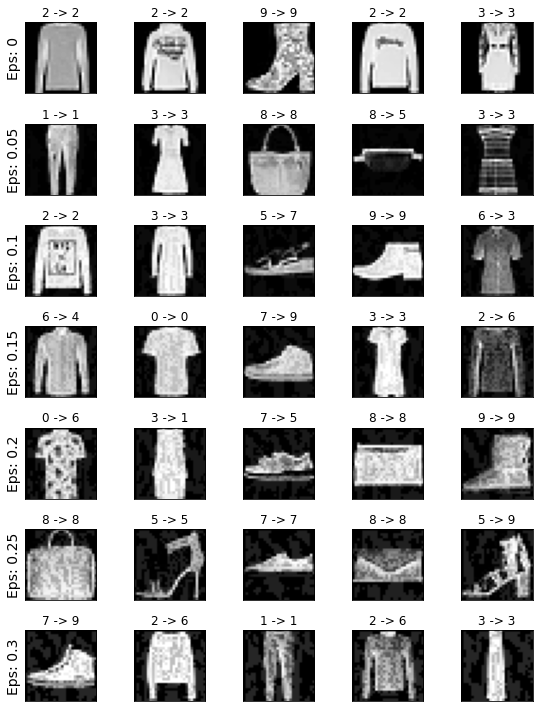

In [74]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(EPSILONS)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(EPSILONS),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(EPSILONS[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
if (USE_OWN_NN):
    if (SPATIAL_SMOOTHING and RESIZE_PADDING):
        plt.savefig(path + "ownModel_" + ATTACK + "_spatialSmoothing&resizePadding_examples.png")
    elif (SPATIAL_SMOOTHING):
        plt.savefig(path + "ownModel_" + ATTACK + "_spatialSmoothing_examples.png")
    elif (RESIZE_PADDING):
        plt.savefig(path + "ownModel_" + ATTACK + "_resizePadding_examples.png")
    else:
        plt.savefig(path + "ownModel_" + ATTACK + "_examples.png")
else:
    if (SPATIAL_SMOOTHING and RESIZE_PADDING):
        plt.savefig(path + "ResNet50_" + ATTACK + "_spatialSmoothing&resizePadding_examples.png")
    elif (SPATIAL_SMOOTHING):
        plt.savefig(path + "ResNet50_" + ATTACK + "_spatialSmoothing_examples.png")
    elif (RESIZE_PADDING):
        plt.savefig(path + "ResNet50_" + ATTACK + "_resizePadding_examples.png")
    else:
        plt.savefig(path + "ResNet50_" + ATTACK + "_examples.png")
plt.show()